# Multi Raw Aspect Modelling

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [31]:
PATH    = "./../data/multiple_raw.csv"

In [32]:
data = pd.read_csv(PATH, usecols=["ProductId", "Score", "Text"])

In [33]:
data.head()

,ProductId,Score,Text
0,2,5,great taffy great taffy great price wide assor...
1,2,5,great good expensive brand saltwater taffy gre...
2,2,5,wonderful tasty taffy taffy good soft chewy fl...
3,3,5,good hot sauce world know cactus tequila uniqu...
4,4,4,fresh greasy good flavor come securely pack fr...


In [52]:
# Return matrix of tfidf for each configuration of documents (rows) and words (columns)
vectorizer  = TfidfVectorizer()
word_sparse = vectorizer.fit_transform(data["Text"])
features    = vectorizer.get_feature_names_out()
columns     = np.concatenate([["ProductId"], features])

In [35]:
product_ids = data["ProductId"].values.reshape(-1,1)
product_ids_sparse = csr_matrix(product_ids)

In [36]:
x = hstack([product_ids, word_sparse])
y = data["Score"].values - 1

In [37]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42
)

In [38]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(87412, 53794)
(87412,)
(21854, 53794)
(21854,)


## Neural Network Classifier

In [39]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 5

epoch_no    = 100
batch_size  = 512

In [40]:
# Define generator for training data
def train_generator():
    for i in range(x_train.shape[0]):
        yield x_train[i].toarray()[0].astype(np.float32), y_train[i]

# Define generator for testing data
def test_generator():
    for i in range(x_test.shape[0]):
        yield x_test[i].toarray()[0].astype(np.float32), y_test[i]

In [41]:
# TensorFlow Datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_train.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_test.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [42]:
# Add layers and activation function to neural network
nn_class    = tf.keras.Sequential()

nn_class.add(Input(shape=(input_dim,)))
nn_class.add(Dense(n_neurons_1, activation='relu'))
nn_class.add(Dense(n_neurons_2, activation='relu'))
nn_class.add(Dense(n_neurons_3, activation='relu'))
nn_class.add(Dense(output_dim, activation='sigmoid'))

# Configure loss function, gradient descent, and evaluation metrics
nn_class.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [43]:
nn_class.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 87s 490ms/step - accuracy: 0.3222 - loss: 12.9366
Epoch 2/100


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


171/171 ━━━━━━━━━━━━━━━━━━━━ 80s 465ms/step - accuracy: 0.4771 - loss: 2.5168
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 86s 504ms/step - accuracy: 0.6566 - loss: 1.1907
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 92s 539ms/step - accuracy: 0.6334 - loss: 1.2947
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 85s 497ms/step - accuracy: 0.6525 - loss: 1.1541
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 84s 494ms/step - accuracy: 0.5699 - loss: 1.7258
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 85s 495ms/step - accuracy: 0.5739 - loss: 2.1557
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 83s 486ms/step - accuracy: 0.6560 - loss: 1.0929
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 84s 493ms/step - accuracy: 0.6472 - loss: 1.1390
Epoch 10/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 84s 492ms/step - accuracy: 0.6459 - loss: 1.1378
Epoch 11/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 73s 427ms/step - accuracy: 0.6417 - loss: 1.1358
Epoch 12/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 87s 511ms/step - accuracy: 0.6061 - loss: 1.6156
Epoch 13/100
171/17

## Neural Network Regressor

In [44]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 1

epoch_no    = 100
batch_size  = 512

In [45]:
# Define generator for training data
def train_generator():
    for i in range(x_train.shape[0]):
        yield x_train[i].toarray()[0].astype(np.float32), y_train[i]

# Define generator for testing data
def test_generator():
    for i in range(x_test.shape[0]):
        yield x_test[i].toarray()[0].astype(np.float32), y_test[i]

In [46]:
# TensorFlow Datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_train.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_test.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [47]:
# Add layers and activation function to neural network
nn_reg    = tf.keras.Sequential()

nn_reg.add(Input(shape=(input_dim,)))
nn_reg.add(Dense(n_neurons_1, activation='relu'))
nn_reg.add(Dense(n_neurons_2, activation='relu'))
nn_reg.add(Dense(n_neurons_3, activation='relu'))
nn_reg.add(Dense(output_dim, activation='linear'))

# Configure loss function, gradient descent, and evaluation metrics
nn_reg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=["mae"]
)

In [48]:
reg_loss = nn_reg.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 110s 623ms/step - loss: 147.3304 - mae: 5.4545
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 99s 574ms/step - loss: 4.2369 - mae: 1.7205
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 101s 591ms/step - loss: 9.9872 - mae: 2.2333
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 98s 573ms/step - loss: 2.9352 - mae: 1.4315
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 104s 606ms/step - loss: 2.6113 - mae: 1.3508
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 96s 562ms/step - loss: 2.1666 - mae: 1.2326
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 102s 598ms/step - loss: 1.9972 - mae: 1.1775
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 98s 572ms/step - loss: 2.8060 - mae: 1.2453
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 109s 639ms/step - loss: 1.8175 - mae: 1.1235
Epoch 10/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 598ms/step - loss: 5.6876 - mae: 1.5530
Epoch 11/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 101s 589ms/step - loss: 1.7335 - mae: 1.0866
Epoch 12/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 109s 636ms/s

## Evaluation

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

683/683 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
0.8440327048301697


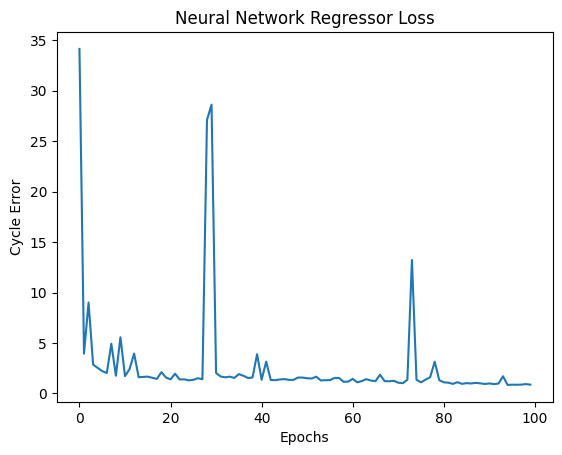

In [50]:
# Neural Network Regression MSE
nn_pred = nn_reg.predict(x_test)
print(mean_squared_error(y_true=y_test, y_pred=nn_pred))

plt.plot(reg_loss.history['loss'])
plt.title("Neural Network Regressor Loss")
plt.xlabel("Epochs")
plt.ylabel("Cycle Error")
plt.show()

In [53]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)  # You can tune alpha later
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

aspect_names = columns  # or provide aspect column names directly
coefficients = ridge.coef_

# Get top contributing aspects
top_positive = sorted(zip(coefficients, aspect_names), reverse=True)[:10]
top_negative = sorted(zip(coefficients, aspect_names))[:10]

print("Top Positive Aspects:")
for coef, name in top_positive:
    print(f"{name}: {coef:.4f}")

print("\nTop Negative Aspects:")
for coef, name in top_negative:
    print(f"{name}: {coef:.4f}")

aspect_map = dict(zip(columns, coefficients))
for key, value in aspect_map.items():
    print(key, value)

MSE: 0.7624
Top Positive Aspects:
great: 2.7963
excellent: 2.3353
good: 2.0886
amazing: 1.9806
seasonal: 1.9639
perfect: 1.9605
love: 1.9420
americolor: 1.9225
praise: 1.9209
delicious: 1.9117

Top Negative Aspects:
disappointing: -4.3593
horrible: -4.3571
deceptive: -4.2675
awful: -4.1125
ripoff: -4.1036
worst: -4.0991
terrible: -3.7610
poor: -3.5684
disappointment: -3.5648
bait: -3.5582
ProductId 1.3039634616873104e-07
00 -0.3585532000796265
000 -0.06913246136086826
0003 0.04626765240931575
000iu 0.0008563095970938818
000mi 0.0
000usd 0.019978226069012894
001 0.056805369158369
00100 -0.07821159757598982
0020100604 0.0029150860103659116
00493 0.0034559713100476455
0060187654 0.0
0060721855 0.04370861830549223
0067575986 0.0029150860103659116
00703 0.0
00704 0.0
0071468633 0.13034332906185594
0071477845 0.001159142737649661
008 0.01231447611030851
00am -0.07931363960883797
00pm -0.1374798268946562
00something 0.11428294499121079
01 0.30951077237197683
01014 -0.053895766109349874
01069 

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

print("Top Contributing Aspects:")
for idx in sorted_idx[:10]:
    print(f"{aspect_names[idx]}: {importances[idx]:.4f}")

MSE: 0.8061
Top Contributing Aspects:
great: 0.0472
bad: 0.0436
good: 0.0307
love: 0.0303
delicious: 0.0249
disappointed: 0.0179
excellent: 0.0144
perfect: 0.0130
money: 0.0128
favorite: 0.0121


683/683 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.48      0.74      0.58      2046
           1       0.17      0.00      0.00      1136
           2       0.15      0.00      0.01      1516
           3       0.15      0.00      0.00      2815
           4       0.76      0.99      0.86     14341

    accuracy                           0.72     21854
   macro avg       0.34      0.35      0.29     21854
weighted avg       0.58      0.72      0.62     21854



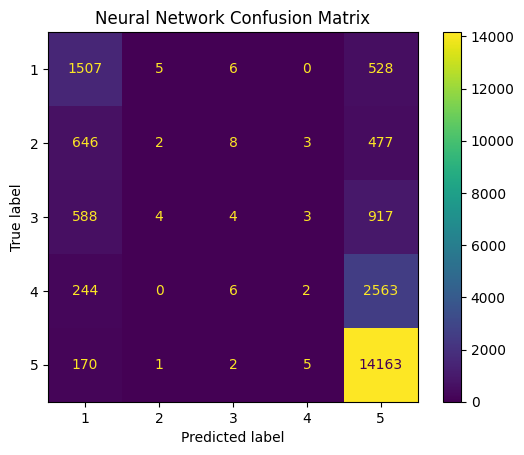

In [55]:
# Neural Network Classification
nn_pred = nn_class.predict(x_test)
nn_pred = [np.argmax(arr) for arr in nn_pred]
print(classification_report(y_pred=nn_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.title("Neural Network Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       0.20      0.13      0.16      2046
           1       0.05      0.02      0.03      1136
           2       0.08      0.03      0.04      1516
           3       0.15      0.09      0.12      2815
           4       0.68      0.85      0.75     14341

    accuracy                           0.58     21854
   macro avg       0.23      0.22      0.22     21854
weighted avg       0.49      0.58      0.53     21854



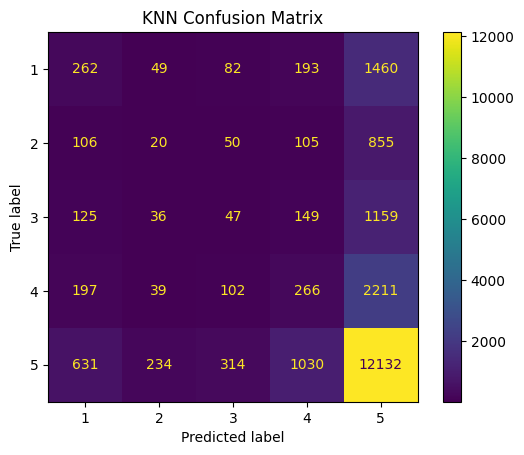

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
print(classification_report(y_pred=knn_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.title("KNN Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.40      0.54      2046
           1       0.98      0.13      0.22      1136
           2       0.84      0.14      0.24      1516
           3       0.96      0.12      0.22      2815
           4       0.71      1.00      0.83     14341

    accuracy                           0.72     21854
   macro avg       0.86      0.36      0.41     21854
weighted avg       0.78      0.72      0.65     21854



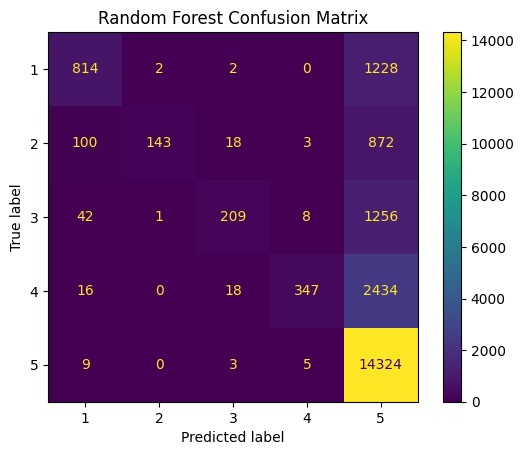

In [57]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classficication
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print(classification_report(y_pred=rf_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()